# **Mount Google drive on colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/CV Project 3/'

/content/drive/MyDrive/CV Project 3


# **Import libraries**

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import torch
from torch import nn
import keras 
#from keras.models import Sequential
from keras import layers
import sklearn.metrics as metrics
from keras import optimizers
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
# from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Step 1** : **Data Pre-processing**

In [ ]:
# Function to perform Data Augmentation
def dataAugmentation(data):
  num_imgs = data.shape[0]
  temp_tensor = torch.empty((num_imgs*3,3,32,32), dtype=torch.float64)
  #print(temp_tensor.shape)
  for i in range(num_imgs):            
    temp_tensor[i,:,:,:] = torch.flip(data[i,:,:,:], (1,2))
    temp_tensor[i+num_imgs,:,:,:] = T.GaussianBlur(kernel_size=(7,7), 
                                               sigma=(0.1, 0.2))(data[i,:,:,:])
    temp_tensor[i+num_imgs*2,:,:] = T.Grayscale(3)(data[i,:,:,:])
  return torch.cat((data,temp_tensor))

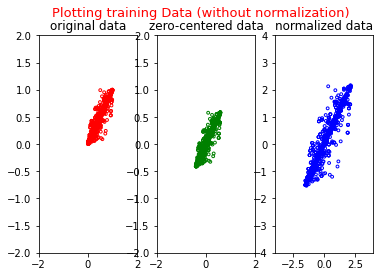

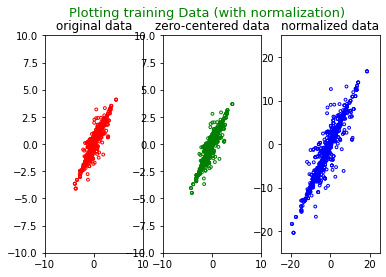

In [ ]:
#Reading the training dataset - Face and Non-face
pos_images_dir = "ExtractedData/allImages/pos/"
neg_images_dir = "ExtractedData/allImages/neg/"
pos_img = os.listdir(pos_images_dir)
neg_img = os.listdir(neg_images_dir)

#Reading the testing dataset - Face and Non-face
pos_testimages_dir = "ExtractedData_chota/ExtractedData/testImages/pos/"
neg_testimages_dir = "ExtractedData_chota/ExtractedData/testImages/neg/"
pos_test_img = os.listdir(pos_testimages_dir)
neg_test_img = os.listdir(neg_testimages_dir)

# Count the number of images in each of the training and testing dataset
positive_training_image_count = len(pos_img)
negative_training_image_count = len(neg_img)
positive_testing_image_count = len(pos_test_img)
negative_testing_image_count = len(neg_test_img)

# Create empty torch.tensors to store training and testing data for each of the Face and Non-Face images
Face_img_train = torch.empty((positive_training_image_count,3,32,32), dtype=torch.float64)
NonFace_img_train = torch.empty((negative_training_image_count,3,32,32), dtype=torch.float64)
Face_img_test = torch.empty((positive_testing_image_count,3,32,32), dtype=torch.float64)
NonFace_img_test = torch.empty((negative_testing_image_count,3,32,32), dtype=torch.float64)

# Define the classes for classification
classes = ('face', 'nonface')

# Loading Face training data as torch.tensor
for i,pos_image in enumerate (pos_img):
    image = cv2.imread(pos_images_dir + pos_image)
    image = cv2.resize(image, (32,32))
    Face_img_train[i,:,:,:] = T.ToTensor()(image)

# Loading Non-Face training data as torch.tensor
for i,neg_image in enumerate (neg_img):
    image = cv2.imread(neg_images_dir + neg_image)
    image = cv2.resize(image, (32,32))
    NonFace_img_train[i,:,:,:] = T.ToTensor()(image)

# Loading Face Testing images as torch.tensor
for i,pos_image in enumerate (pos_test_img):
    image = cv2.imread(pos_testimages_dir + pos_image)
    image = cv2.resize(image, (32,32))
    Face_img_test[i,:,:,:] = T.ToTensor()(image)

# Loading Non-Face Testing images as torch.tensor
for i,neg_image in enumerate (neg_test_img):
    image = cv2.imread(neg_testimages_dir + neg_image)
    image = cv2.resize(image, (32,32))
    NonFace_img_test[i,:,:,:] = T.ToTensor()(image)

# Performing Data Augmentation for training images
Face_img_train = dataAugmentation(Face_img_train)
NonFace_img_train = dataAugmentation(NonFace_img_train)

# Performing Data Augmentation for testing images
Face_img_test = dataAugmentation(Face_img_test)
NonFace_img_test = dataAugmentation(NonFace_img_test)

# Combine the training data for both Face and Non-face in a single tensor
training_imgs = torch.cat((Face_img_train,NonFace_img_train))

# Combine the testing data for both Face and Non-face in a single tensor
testing_imgs = torch.cat((Face_img_test, NonFace_img_test))

# Assign labels for both Face and Non-face training data in a single tensor - Assign 1 for Face & 0 for Non-Face
training_labels = torch.cat((torch.ones(training_imgs.shape[0]//2), torch.zeros(training_imgs.shape[0]//2)))

# Assign labels for both Face and Non-face testing data in a single tensor - Assign 1 for Face & 0 for Non-Face
testing_labels = torch.cat((torch.ones(testing_imgs.shape[0]//2), torch.zeros(testing_imgs.shape[0]//2)))

# Flatten the training_imgs array for ease of pre-processing
training_imgs_flattened = training_imgs.flatten(start_dim=1)

# Calculate mean of the training data
mean_data = np.mean(np.array(training_imgs_flattened), axis=0)

# Calculate standard deviation of the training data
std_data = np.std(np.array(training_imgs_flattened), axis=0)

##################################################################################################################
#                                                                                                                #
#                  Step 1 : Data Preprocessing (as per Slide number 4 in project03 description)                  #
#                                                                                                                #
##################################################################################################################

# ================================================================================================================
#                               Plotting Training Data : without normalization 
# ================================================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Plotting training Data (without normalization)',color = "red",fontsize=13)

ax1.scatter(training_imgs_flattened[:,0], training_imgs_flattened[:,1], color="red",facecolor='none', s=8)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_title('original data')

# Substracting mean from each image to give us a zero-centred data
training_imgs_zeroCentred = training_imgs_flattened - mean_data

ax2.scatter(training_imgs_zeroCentred[:,0], training_imgs_zeroCentred[:,1], color='green', facecolor='none', s=8)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_title('zero-centered data')

# Dividing by standard deviation to give a zero-centred normalized data
training_imgs_Normalized = training_imgs_zeroCentred/std_data

ax3.scatter(training_imgs_Normalized[:,0], training_imgs_Normalized[:,1], color='blue', facecolor='none', s=8)
ax3.set_xlim(-4, 4)
ax3.set_ylim(-4, 4)
ax3.set_title('normalized data')
plt.show()

# Calculate mean and standard deviation of all the training images in the dataset
for i in range(training_imgs.shape[0]):
  mean_data, std_dev_data = training_imgs[i,:,:,:].mean([1,2]), training_imgs[i,:,:,:].std([1,2])
  training_imgs[i,:,:,:] = T.Normalize(mean_data, std_dev_data)(training_imgs[i,:,:,:])

# Flatten the training_imgs array for ease of pre-processing
training_imgs_normalized_flattened = training_imgs.flatten(start_dim=1)

# ================================================================================================================
#                               Plotting Training Data : with normalization 
# ================================================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Plotting training Data (with normalization)',color = "green", fontsize=13)
ax1.scatter(training_imgs_normalized_flattened[:,0], training_imgs_normalized_flattened[:,1], color="red",facecolor='none', s=8)
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.set_title('original data')

# Substracting mean from each image to give us a zero-centred data
training_imgs_zeroCentred = training_imgs_normalized_flattened - mean_data[0]

ax2.scatter(training_imgs_zeroCentred[:,0], training_imgs_zeroCentred[:,1], color='green', facecolor='none', s=8)
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_title('zero-centered data')

# Dividing by standard deviation to give a zero-centred normalized data
training_imgs_Normalized = training_imgs_zeroCentred/std_dev_data[0]

ax3.scatter(training_imgs_Normalized[:,0], training_imgs_Normalized[:,1], color='blue', facecolor='none', s=8)
ax3.set_xlim(-25, 25)
ax3.set_ylim(-25, 25)
ax3.set_title('normalized data')
plt.show()


In [ ]:
# Define relevant hyperparameters for training the model
batch_size = 1
num_classes = 2
learning_rate = 0.0005
num_epochs = 20

In [ ]:
# Form the training, validation, and testing dataset using DataLoader class
x_train, x_val, y_train, y_val =train_test_split(training_imgs, 
                                              training_labels, train_size=0.8)
train_loader = DataLoader(dataset = ([[x_train[i], y_train[i]] 
                                      for i in range(len(y_train))]),
                                           batch_size = batch_size,
                                           shuffle = True)

validation_loader = DataLoader(dataset = ([[x_val[i], y_val[i]] 
                                           for i in range(len(y_val))]),
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = DataLoader(dataset = ([[testing_imgs[i], testing_labels[i]] 
                                     for i in range(len(testing_labels))]),
                                           batch_size = batch_size,
                                           shuffle = True)

# **Step 2 - Choose the Architecture** :  LeNet 

The architecture is designed such that it can be used to realise the performance of model with and without batch normalization. We need to make sure that *nn.BatchNorm2d(6)* and *nn.BatchNorm2d(16)* lines of code in the cell below are commented if we want to define the model without any standard regularization method, i.e., batch normalization in our project. Likewise, if we want to get a model with batch normalization, we should make sure that the above line of code remain uncommented.

For our demonstration, we keep the batch normalization layer in our model. We used **ReLu activation** function in the model.






In [ ]:
#Defining the convolutional neural network 
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
net = LeNet5(2).to(device)
print(net)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=2, bias=True)
)


# **Step 3**

Checking that the loss is reasonable. For two classes, the loss should be equal to log(2), which is equal to 0.693

In [ ]:
# Load the model 
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
model = model.double() 

# Printing training loss 
for epoch in range(1):
    train_loss = 0.0
    valid_loss = 0.0
    print ("Printing loss for first epoch")
    for i, (images, labels) in enumerate(train_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward Propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        if (i+1) % 960 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, 
                             loss.item()))


    model.eval()
    for i, (images, labels) in enumerate(validation_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())
        valid_loss += loss.item()*images.size(0)
        if (i+1) % 240 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, 
                             loss.item()))

Printing loss for first epoch
Epoch [1/20], Step [960/960], Training Loss: 0.6954
Epoch [1/20], Step [240/960], Validation Loss: 0.6655


# **Step 4**

Adding small regularizer to the model

In [ ]:
# Load the model 
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=0.0000001)

#scheduler = ExponentialLR(optimizer, gamma=0.9)

total_step = len(train_loader)
model = model.double() 

# Printing training loss 
for epoch in range(1):
    train_loss = 0.0
    valid_loss = 0.0
    print ("Printing loss for first epoch")
    for i, (images, labels) in enumerate(train_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward Propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        if (i+1) % 960 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, 
                             loss.item()))


    model.eval()
    for i, (images, labels) in enumerate(validation_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())
        valid_loss += loss.item()*images.size(0)
        if (i+1) % 240 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, 
                             loss.item()))

Printing loss for first epoch
Epoch [1/20], Step [960/960], Training Loss: 0.7217
Epoch [1/20], Step [240/960], Validation Loss: 0.6364


# **Step 5**

Overfitting Data - learning rate is tuned and set to 0.03 for overfitting

In [ ]:
# Load 20 images in the dataloader to check overfitting
overfit_data_loader = DataLoader(dataset = ([[x_train[i], y_train[i]] for i in range(20)]),
                                           batch_size = batch_size,
                                           shuffle = True)

In [ ]:
# Define relevant hyperparameters for training the model
batch_size = 1
num_classes = 2
learning_rate = 0.03
num_epochs = 20

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
model = model.double() 
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_samples = 0.0
    valid_samples = 0.0
    total, correct = 0 , 0
    total_Val, correct_Val = 0 , 0

    for i, (images, labels) in enumerate(overfit_data_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_samples += images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        train_accuracy = float(correct)/len(overfit_data_loader)

        if (i+1) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}, Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, train_accuracy, loss.item()))

    model.eval()
    for i, (images, labels) in enumerate(overfit_data_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())

        valid_loss += loss.item()*images.size(0)
        train_loss += loss.item()*images.size(0)
        valid_samples += images.size(0)
        _, predicted = torch.max(output.data, 1)
        total_Val+=labels.size(0)
        correct_Val+=(predicted==labels).sum().item()
        val_accuracy = float(correct_Val)/len(overfit_data_loader)
        if (i+1) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Accuracy: {:.4f}, Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, val_accuracy, loss.item()))

0
Epoch [1/20], Step [20/960], Training Accuracy: 0.3500, Training Loss: 0.7015
Epoch [1/20], Step [20/960], Validation Accuracy: 0.5000, Validation Loss: 0.7321
1
Epoch [2/20], Step [20/960], Training Accuracy: 0.5000, Training Loss: 0.7423
Epoch [2/20], Step [20/960], Validation Accuracy: 0.9000, Validation Loss: 0.6928
2
Epoch [3/20], Step [20/960], Training Accuracy: 0.6000, Training Loss: 0.6590
Epoch [3/20], Step [20/960], Validation Accuracy: 0.7500, Validation Loss: 0.6837
3
Epoch [4/20], Step [20/960], Training Accuracy: 0.6000, Training Loss: 0.6862
Epoch [4/20], Step [20/960], Validation Accuracy: 0.8500, Validation Loss: 0.5782
4
Epoch [5/20], Step [20/960], Training Accuracy: 0.7500, Training Loss: 0.5671
Epoch [5/20], Step [20/960], Validation Accuracy: 0.7000, Validation Loss: 0.3671
5
Epoch [6/20], Step [20/960], Training Accuracy: 0.7500, Training Loss: 0.1915
Epoch [6/20], Step [20/960], Validation Accuracy: 0.6000, Validation Loss: 0.4660
6
Epoch [7/20], Step [20/960

# **Step 6**

Adding small regularization to the model and varying the learning rate that minimizes the loss. Realise the impact of variation of learning rate to vary the loss as required - **getting the loss go down, getting "nan" and "inf" values**.

In [ ]:
# Define relevant hyperparameters for training the model
# learning rate is varied to find a good value that minimizes the loss.
# learning rate = 0.0001 -> Loss is barely changing. Learning rate is too small.
# learning rate = 0.0005 -> Loss is comming down 
# learning rate = 3e6 -> we are getting nan. Learning rate is too high.
batch_size = 1
num_classes = 2
learning_rate = 3e-6
num_epochs = 20

In [ ]:
# Load the model 
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=0.0000001)

#scheduler = ExponentialLR(optimizer, gamma=0.9)

total_step = len(train_loader)
model = model.double() 

# Printing training loss 
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward Propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        if (i+1) % 960 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, 
                             loss.item()))


    model.eval()
    for i, (images, labels) in enumerate(validation_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())
        valid_loss += loss.item()*images.size(0)
        if (i+1) % 240 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, 
                             loss.item()))

Epoch [1/20], Step [960/960], Training Loss: 0.7537
Epoch [1/20], Step [240/960], Validation Loss: 0.6287
Epoch [2/20], Step [960/960], Training Loss: 0.6458
Epoch [2/20], Step [240/960], Validation Loss: 0.7437
Epoch [3/20], Step [960/960], Training Loss: 0.7443
Epoch [3/20], Step [240/960], Validation Loss: 0.7559
Epoch [4/20], Step [960/960], Training Loss: 0.7357
Epoch [4/20], Step [240/960], Validation Loss: 0.6434
Epoch [5/20], Step [960/960], Training Loss: 0.7423
Epoch [5/20], Step [240/960], Validation Loss: 0.6369
Epoch [6/20], Step [960/960], Training Loss: 0.7258
Epoch [6/20], Step [240/960], Validation Loss: 0.6405
Epoch [7/20], Step [960/960], Training Loss: 0.7382
Epoch [7/20], Step [240/960], Validation Loss: 0.7328
Epoch [8/20], Step [960/960], Training Loss: 0.7389
Epoch [8/20], Step [240/960], Validation Loss: 0.7369
Epoch [9/20], Step [960/960], Training Loss: 0.7289
Epoch [9/20], Step [240/960], Validation Loss: 0.6333
Epoch [10/20], Step [960/960], Training Loss: 

# **Step 7 :** **Testing the model's performance**

Evaluating the performance of the model on the testing data from the FDDB dataset with and without Standard regularization. Here we are using Batch Normalization. 

**Note**

*Results for Batch Normalization can be obtained by uncommenting 2 lines of code in the network architecture defined in Step (2). Commented lines are also shown below*


1.   nn.BatchNorm2d(6)
2.   nn.BatchNorm2d(16)

After this, please run the code in the first cell defined in  Step (2) and then run all the cells in step (7) to get the Testing Accuracy


Now, the model with batch normalization is active, i.e, both the above listed lines of code are uncommented in the architecture defined in step (2). In order to view results for the model without Batch Normalization, these lines need to be commented back.

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
def Calculate_accuracy_TestDataset(model, test_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))


In [ ]:
# Define relevant hyperparameters for training the model
batch_size = 1
num_classes = 2
learning_rate = 0.00065
num_epochs = 7

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=1e-5)

total_step = len(train_loader)
model = model.double() 
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_samples = 0.0
    valid_samples = 0.0
    total, correct = 0 , 0
    total_Val, correct_Val = 0 , 0
    for i, (images, labels) in enumerate(train_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_samples += images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        train_accuracy = float(correct)/len(train_loader)

        if (i+1) % 960 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}, Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, train_accuracy, loss.item()))

    model.eval()
    for i, (images, labels) in enumerate(validation_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())

        valid_loss += loss.item()*images.size(0)
        train_loss += loss.item()*images.size(0)
        valid_samples += images.size(0)
        _, predicted = torch.max(output.data, 1)
        total_Val+=labels.size(0)
        correct_Val+=(predicted==labels).sum().item()
        val_accuracy = float(correct_Val)/len(validation_loader)
        if (i+1) % 240 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Accuracy: {:.4f}, Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, val_accuracy, loss.item()))

Epoch [1/7], Step [960/960], Training Accuracy: 0.7177, Training Loss: 0.5302
Epoch [1/7], Step [240/960], Validation Accuracy: 0.7833, Validation Loss: 0.5793
Epoch [2/7], Step [960/960], Training Accuracy: 0.8021, Training Loss: 1.2066
Epoch [2/7], Step [240/960], Validation Accuracy: 0.8833, Validation Loss: 0.0471
Epoch [3/7], Step [960/960], Training Accuracy: 0.9052, Training Loss: 0.0395
Epoch [3/7], Step [240/960], Validation Accuracy: 0.9250, Validation Loss: 0.0709
Epoch [4/7], Step [960/960], Training Accuracy: 0.9563, Training Loss: 0.3966
Epoch [4/7], Step [240/960], Validation Accuracy: 0.9667, Validation Loss: 0.0134
Epoch [5/7], Step [960/960], Training Accuracy: 0.9667, Training Loss: 0.0010
Epoch [5/7], Step [240/960], Validation Accuracy: 0.9792, Validation Loss: 0.2471
Epoch [6/7], Step [960/960], Training Accuracy: 0.9865, Training Loss: 0.0017
Epoch [6/7], Step [240/960], Validation Accuracy: 0.9667, Validation Loss: 0.4276
Epoch [7/7], Step [960/960], Training Ac

In [ ]:
Calculate_accuracy_TestDataset(model,test_loader)

Accuracy of the network on the test images: 91.75 %


# **Step 8 :**  **Cross-validation Strategy**

PyTorch provides several methods to adjust the learning rate based on the number of epochs. In this project, we are using **ReduceLROnPlateau** scheduler to optimize learning rate.

This type of scheduler reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a patience number of epochs, the learning rate is reduced.

The argument "*patience = 5*" means that the scheduler will check if validation loss does not decrease for 5 epochs, the scheduler decreases the learning rate

In [ ]:
# Define relevant hyperparameters for training the model
batch_size = 1
num_classes = 2
learning_rate = 0.00055
num_epochs = 20

In [ ]:
model = LeNet5(num_classes).to(device)

# Setting the loss function
cost = nn.CrossEntropyLoss()

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=1e-5)

# Adding ReduceLROnPlateau to vary learning rate. 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

total_step = len(train_loader)
model = model.double() 
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_samples = 0.0
    valid_samples = 0.0
    total, correct = 0 , 0
    total_Val, correct_Val = 0 , 0
    for i, (images, labels) in enumerate(train_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_samples += images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        train_accuracy = float(correct)/len(train_loader)

        if (i+1) % 960 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}, Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, train_accuracy, loss.item()))

    model.eval()
    for i, (images, labels) in enumerate(validation_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())

        valid_loss += loss.item()*images.size(0)
        train_loss += loss.item()*images.size(0)
        valid_samples += images.size(0)
        _, predicted = torch.max(output.data, 1)
        total_Val+=labels.size(0)
        correct_Val+=(predicted==labels).sum().item()
        val_accuracy = float(correct_Val)/len(validation_loader)
        if (i+1) % 240 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Accuracy: {:.4f}, Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, val_accuracy, loss.item()))
    curr_lr = optimizer.param_groups[0]['lr']
    print('Current Learning Rate : ', curr_lr)

    # Passing validation_loss as an argument for checking upto 5 number of epochs.
    # patience = 5 means that the scheduler will check if validation loss does not
    # decrease for 5 epochs, the scheduler decreases the learning rate
    scheduler.step(valid_loss/len(validation_loader))

Epoch [1/20], Step [960/960], Training Accuracy: 0.6896, Training Loss: 0.6388
Epoch [1/20], Step [240/960], Validation Accuracy: 0.7958, Validation Loss: 0.5726
Current Learning Rate :  0.00055
Epoch [2/20], Step [960/960], Training Accuracy: 0.8104, Training Loss: 0.1607
Epoch [2/20], Step [240/960], Validation Accuracy: 0.8792, Validation Loss: 0.2551
Current Learning Rate :  0.00055
Epoch [3/20], Step [960/960], Training Accuracy: 0.8833, Training Loss: 0.1005
Epoch [3/20], Step [240/960], Validation Accuracy: 0.9458, Validation Loss: 0.0354
Current Learning Rate :  0.00055
Epoch [4/20], Step [960/960], Training Accuracy: 0.9333, Training Loss: 0.0102
Epoch [4/20], Step [240/960], Validation Accuracy: 0.9542, Validation Loss: 0.1212
Current Learning Rate :  0.00055
Epoch [5/20], Step [960/960], Training Accuracy: 0.9646, Training Loss: 0.0180
Epoch [5/20], Step [240/960], Validation Accuracy: 0.9792, Validation Loss: 0.0029
Current Learning Rate :  0.00055
Epoch [6/20], Step [960/9

Calculate accuracy on test dataset

In [ ]:
Calculate_accuracy_TestDataset(model,test_loader)

Accuracy of the network on the test images: 61.25 %


In [ ]:
# Define relevant hyperparameters for training the model
batch_size = 1
num_classes = 2
learning_rate = 0.000045
num_epochs = 50

In [ ]:
model = LeNet5(num_classes).to(device)

# Setting the loss function
cost = nn.CrossEntropyLoss()

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=1e-5)

# Adding ReduceLROnPlateau to vary learning rate. 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

total_step = len(train_loader)
model = model.double() 
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_samples = 0.0
    valid_samples = 0.0
    total, correct = 0 , 0
    total_Val, correct_Val = 0 , 0
    for i, (images, labels) in enumerate(train_loader, 0):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = cost(outputs, labels.long())
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_samples += images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        train_accuracy = float(correct)/len(train_loader)

        if (i+1) % 960 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}, Training Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, train_accuracy, loss.item()))

    model.eval()
    for i, (images, labels) in enumerate(validation_loader, 0):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = cost(output, labels.long())

        valid_loss += loss.item()*images.size(0)
        train_loss += loss.item()*images.size(0)
        valid_samples += images.size(0)
        _, predicted = torch.max(output.data, 1)
        total_Val+=labels.size(0)
        correct_Val+=(predicted==labels).sum().item()
        val_accuracy = float(correct_Val)/len(validation_loader)
        if (i+1) % 240 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Validation Accuracy: {:.4f}, Validation Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, val_accuracy, loss.item()))
    curr_lr = optimizer.param_groups[0]['lr']
    print('Current Learning Rate : ', curr_lr)

    # Passing validation_loss as an argument for checking upto 5 number of epochs.
    # patience = 5 means that the scheduler will check if validation loss does not
    # decrease for 5 epochs, the scheduler decreases the learning rate
    scheduler.step(valid_loss/len(validation_loader))

Epoch [1/50], Step [960/960], Training Accuracy: 0.5771, Training Loss: 0.6007
Epoch [1/50], Step [240/960], Validation Accuracy: 0.5292, Validation Loss: 0.6159
Current Learning Rate :  4.5e-05
Epoch [2/50], Step [960/960], Training Accuracy: 0.5979, Training Loss: 0.6483
Epoch [2/50], Step [240/960], Validation Accuracy: 0.6167, Validation Loss: 0.5919
Current Learning Rate :  4.5e-05
Epoch [3/50], Step [960/960], Training Accuracy: 0.6594, Training Loss: 0.5269
Epoch [3/50], Step [240/960], Validation Accuracy: 0.6833, Validation Loss: 0.6890
Current Learning Rate :  4.5e-05
Epoch [4/50], Step [960/960], Training Accuracy: 0.7083, Training Loss: 0.5606
Epoch [4/50], Step [240/960], Validation Accuracy: 0.6917, Validation Loss: 0.7704
Current Learning Rate :  4.5e-05
Epoch [5/50], Step [960/960], Training Accuracy: 0.7427, Training Loss: 0.6395
Epoch [5/50], Step [240/960], Validation Accuracy: 0.7417, Validation Loss: 0.6317
Current Learning Rate :  4.5e-05
Epoch [6/50], Step [960/9

In [ ]:
Calculate_accuracy_TestDataset(model,test_loader)

Accuracy of the network on the test images: 63.25 %


#                      ----------------                        **END OF NOTEBOOK**                       --------------